# 📚 Sinhala Mithuru Research Project
## Module A: Handwriting Character Recognition Engine

### 🟢 SECTION 1: SYSTEM INITIALIZATION & DEPENDENCIES

**Description:**
This block initializes the research environment by importing essential libraries for deep learning, statistical analysis, and data visualization.

**Scientific Rationale:**
- **TensorFlow/Keras:** Used for constructing Recurrent Neural Networks (RNNs) due to their robust support for temporal data.
- **GPU Acceleration:** Ensuring hardware acceleration is critical for training Long Short-Term Memory (LSTM) networks to handle the computational intensity of **Backpropagation Through Time (BPTT)**.

In [1]:
!pip install -q imbalanced-learn joblib scikit-learn tensorflow matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Masking, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Check for Hardware Acceleration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"✅ GPU Acceleration Enabled: {tf.test.gpu_device_name()}")
else:
    print("⚠️ Warning: Training on CPU. Performance may be degraded.")

2026-01-04 00:10:02.504465: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-04 00:10:02.609888: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ GPU Acceleration Enabled: /device:GPU:0


I0000 00:00:1767485409.302875     105 gpu_device.cc:2020] Created device /device:GPU:0 with 13759 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1b.0, compute capability: 7.5


### 🟢 SECTION 2: DATASET EXTRACTION & DIRECTORY PREPARATION

**Description:**
This block handles the extraction of the compressed dataset (ZIP) into the runtime environment. It also verifies the directory structure to ensure that the character labels and stroke data are correctly placed for further discovery.

**Scientific Rationale:**
In research workflows, particularly when utilizing cloud instances like Google Colab, transferring large numbers of small files (like thousands of JSONs) individually is inefficient. Storing them in a compressed archive minimizes I/O overhead and prevents metadata corruption during the upload process.

In [6]:
import zipfile
import os

# Define the source path and target extraction directory
zip_path = 'json.zip'
extract_dir = './'

# Rationale: Creating a directory if it doesn't exist to prevent 'FileNotFound' errors
os.makedirs(extract_dir, exist_ok=True)

# Extracting the dataset
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset successfully extracted to: {extract_dir}")
except FileNotFoundError:
    print(f"❌ Error: The file {zip_path} was not found. Please upload the 'json.zip' file to the /content/ folder.")

# Verifying the extracted contents
print("📂 Contents of the directory:")
print(os.listdir(extract_dir))

✅ Dataset successfully extracted to: ./
📂 Contents of the directory:
['.bashrc', '.cache', '.profile', '.wget-hsts', '.ssh', '.ipython', '.config', '.keras', '.nv', 'json.zip', 'json']


### 🟢 SECTION 3: GLOBAL EXPERIMENT CONFIGURATION

**Description:**
This section defines the core hyperparameters and global constants that govern the entire training pipeline.

**Research Parameters:**
- **max_seq_length (150):** Standardized input sequence length to manage varying handwriting speeds across users.
- **features (5):** Captures multi-dimensional data including spatial coordinates (x, y), velocity (dx, dy), and pen state (p).
- **batch_size (256):** Optimized for training stability and convergence speed on hardware like Tesla T4 GPUs.

In [7]:
def discover_classes(json_path):
    labels = set()
    for sub_dir in ["correct", "wrong"]:
        path = os.path.join(json_path, sub_dir)
        if os.path.exists(path):
            for fname in os.listdir(path):
                if fname.endswith(".json") and "_" in fname:
                    labels.add(fname.split('_')[0])
    return sorted(list(labels))

BASE_DIR = "json"
DYNAMIC_CLASSES = discover_classes(BASE_DIR)

CONFIG = {
    "max_seq_length": 150,
    "features": 5,           # x, y, dx, dy, p (coordinate and state data)
    "canvas_size": 600,
    "classes": DYNAMIC_CLASSES,
    "test_size": 0.2,
    "epochs": 100,
    "batch_size": 256
}

class_map = {label: i for i, label in enumerate(CONFIG["classes"])}
print(f"📊 Identified Classes: {len(DYNAMIC_CLASSES)}")

📊 Identified Classes: 38


### 🟢 SECTION 4: FEATURE ENGINEERING & SIGNAL PROCESSING

**Description:**
This module performs feature extraction and **Linear Interpolation** on the raw handwriting strokes.

**Scientific Rationale:**
Handwriting is essentially a time-series signal. Since individuals write at different speeds, the number of recorded points varies significantly. Linear Interpolation is employed to resample and normalize every stroke into a fixed sequence of 150 points. This ensures a consistent input shape for the neural network, regardless of the actual writing duration.

In [8]:
def extract_features_direct(strokes):
    pts = []
    for s in strokes:
        for p_val in s:
            pts.append([
                p_val.get('x', 0), p_val.get('y', 0),
                p_val.get('dx', 0), p_val.get('dy', 0),
                p_val.get('p', 0)
            ])
            
    if len(pts) < 5: return None
    path = np.array(pts, dtype='float32')

    # Path distance calculation for interpolation
    dist = np.sqrt(np.sum(np.diff(path[:, :2], axis=0)**2, axis=1))
    cum_dist = np.insert(np.cumsum(dist), 0, 0)
    if cum_dist[-1] == 0: return None

    # Resampling to a fixed temporal resolution
    interp_d = np.linspace(0, cum_dist[-1], CONFIG["max_seq_length"])
    nx = np.interp(interp_d, cum_dist, path[:, 0]) / CONFIG["canvas_size"]
    ny = np.interp(interp_d, cum_dist, path[:, 1]) / CONFIG["canvas_size"]
    ndx = np.interp(interp_d, cum_dist, path[:, 2])
    ndy = np.interp(interp_d, cum_dist, path[:, 3])
    np_state = np.round(np.interp(interp_d, cum_dist, path[:, 4]))

    return np.stack([nx, ny, ndx, ndy, np_state], axis=1)

### 🟢 SECTION 5: DATASET INTEGRATION & EXPLORATORY DATA ANALYSIS (EDA)

**Description:**
This block loads the processed JSON handwriting samples and organizes them into a unified structure for analysis.

**Research Significance:**
Visualizing the **Class Distribution** is a vital step in Exploratory Data Analysis. It allows us to identify data imbalance, where certain characters may have fewer samples than others. A skewed distribution can significantly bias the model toward majority classes if not corrected.

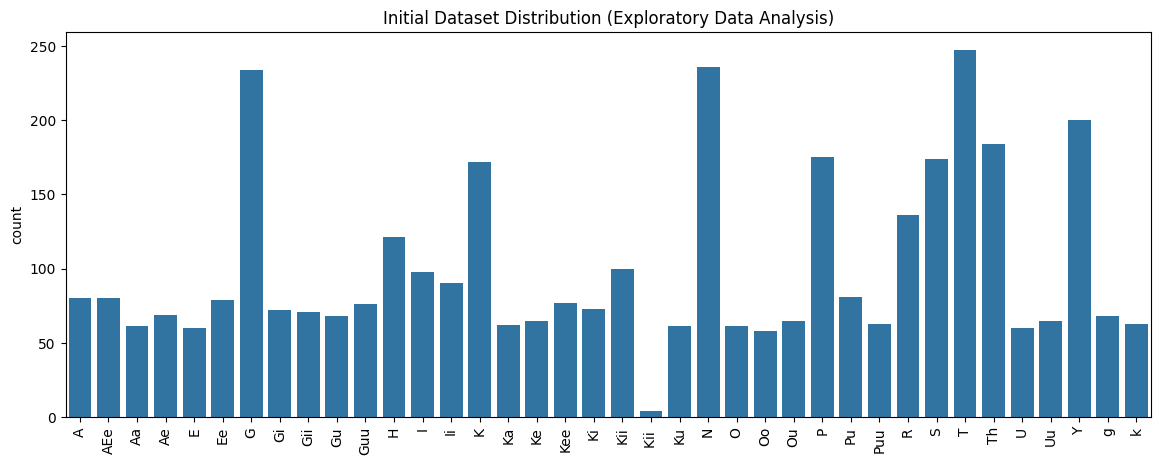

In [9]:
X_raw, y_char = [], []

for label in CONFIG["classes"]:
    for q_type in ["correct", "wrong"]:
        path = os.path.join(BASE_DIR, q_type)
        if not os.path.exists(path): continue
        files = [f for f in os.listdir(path) if f.startswith(label + "_")]
        for f in files:
            with open(os.path.join(path, f), 'r') as file:
                feat = extract_features_direct(json.load(file)['strokes'])
                if feat is not None:
                    X_raw.append(feat)
                    y_char.append(class_map[label])

X, y_c = np.array(X_raw), np.array(y_char)

# Research Visualization: Class Distribution

plt.figure(figsize=(14, 5))
sns.countplot(x=[CONFIG["classes"][i] for i in y_c])
plt.xticks(rotation=90)
plt.title("Initial Dataset Distribution (Exploratory Data Analysis)")
plt.show()

### 🟢 SECTION 6: DATA NORMALIZATION & SYNTHETIC BALANCING

**Description:**
This phase involves Z-score Normalization and the application of **SMOTE (Synthetic Minority Over-sampling Technique)**.

**Scientific Rationale:**
1. **Z-score Standardization:** Centers all features ($x, y, dx, dy$) around a mean of 0 with a unit variance. This stabilizes gradient updates and speeds up convergence in LSTM networks.
   $$z = \frac{x - \mu}{\sigma}$$
2. **SMOTE Balancing:** For under-represented characters, SMOTE generates synthetic samples rather than just duplicating existing ones. This forces the model to learn more generalized decision boundaries for minority classes.

In [10]:
# Feature Scaling
n, s, f = X.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, f)).reshape(n, s, f)
joblib.dump(scaler, 'char_scaler_v1.pkl') # Persisting the scaling parameters

# Validation Split
X_train, X_test, y_c_train, y_c_test = train_test_split(
    X_scaled, y_c, test_size=CONFIG["test_size"], random_state=42, stratify=y_c
)

# Class Balancing
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_res, y_c_train_bal = smote.fit_resample(X_train.reshape(len(X_train), -1), y_c_train)
X_train_bal = X_train_res.reshape(-1, s, f)

print(f"✅ Balancing Complete. Final Training Samples: {len(X_train_bal)}")

✅ Balancing Complete. Final Training Samples: 7524


### 🟢 SECTION 7: NEURAL ARCHITECTURE DESIGN (LSTM)

**Description:**
Defining the Recurrent Neural Network (RNN) architecture optimized for sequence classification.

**Scientific Rationale:**
**LSTM (Long Short-Term Memory)** units are chosen for their ability to maintain a "cell state," allowing the model to remember long-term dependencies within a stroke (e.g., the relationship between the beginning and the end of a character). **Masking Layers** are integrated to ensure the model ignores any zero-padding added during preprocessing.

In [11]:
def build_character_recognition_model():
    inputs = Input(shape=(CONFIG["max_seq_length"], CONFIG["features"]), name="Stroke_Input")
    mask = Masking(mask_value=0.0)(inputs)
    
    # Encoder LSTM Layer
    x = LSTM(128, return_sequences=True, dropout=0.3)(mask)
    x = BatchNormalization()(x)
    
    # Decoder LSTM Layer
    x = LSTM(64, dropout=0.3)(x)
    
    # Fully Connected Decision Layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    
    # Final Classification Layer (Softmax Probability Distribution)
    outputs = Dense(len(CONFIG["classes"]), activation='softmax', name="Classification_Layer")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

char_model = build_character_recognition_model()
char_model.summary()

I0000 00:00:1767486372.064387     105 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13759 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1b.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Stroke_Input (InputLayer)     │ (None, 150, 5)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 150, 5)            │               0 │ Stroke_Input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking (Masking)             │ (None, 150, 5)            │               0 │ Stroke_Input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any (Any)                     │ (None, 150)               │               0 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 150, 128)          │          68,608 │ masking[0][0], any[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 150, 128)          │             512 │ lstm[0][0], any[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 64)                │          49,408 │ batch_normalization[0][0], │
│                               │                           │                 │ any[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │           8,320 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Classification_Layer (Dense)  │ (None, 38)                │           4,902 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 131,750 (514.65 KB)

 Trainable params: 131,494 (513.65 KB)

 Non-trainable params: 256 (1.00 KB)

### 🟢 SECTION 8: TRAINING ENGINE & EVALUATION CALLBACKS

**Description:**
Execution of the training loop using adaptive learning rates and automated monitoring.

**Scientific Rationale:**
- **EarlyStopping:** Halts training automatically when validation accuracy plateaus, effectively preventing **Overfitting**.
- **ReduceLROnPlateau:** Dynamically reduces the learning rate when the loss stops improving, allowing the model to converge more precisely toward the global minimum.
- **ModelCheckpoint:** Automatically persists the "best" iteration of the model based on validation performance.

In [12]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
    ModelCheckpoint('character_recognizer_best.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

print("🚀 Neural Network Training Initiated...")
history_char = char_model.fit(
    X_train_bal, y_c_train_bal,
    validation_data=(X_test, y_c_test),
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    callbacks=callbacks,
    verbose=1
)

🚀 Neural Network Training Initiated...
Epoch 1/100


2026-01-04 00:26:34.982096: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.0601 - loss: 3.4929 - val_accuracy: 0.1010 - val_loss: 3.4267 - learning_rate: 5.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1179 - loss: 3.1333 - val_accuracy: 0.2572 - val_loss: 3.0878 - learning_rate: 5.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2000 - loss: 2.7356 - val_accuracy: 0.3950 - val_loss: 2.6218 - learning_rate: 5.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2767 - loss: 2.3678 - val_accuracy: 0.4239 - val_loss: 2.2233 - learning_rate: 5.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3397 - loss: 2.0753 - val_accuracy: 0.4606 - val_loss: 1.8972 - learning_rate: 5.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4091 - loss: 1.8311 - val_accuracy: 0.4528 - val_loss: 1.6412 - learning_rate: 5.0000e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4724 - los

### 🟢 SECTION 9: QUANTITATIVE PERFORMANCE EVALUATION

**Description:**
This section focuses on statistically evaluating the trained LSTM model using unseen test data. Key metrics such as **Precision**, **Recall**, and **F1-Score** are calculated.

**Scientific Rationale:**
In a 38-class classification problem like Sinhala handwriting, overall accuracy can be misleading. A **Confusion Matrix** is essential to identify specific "class confusion" (e.g., the model confusing 'ග' with 'ත'). 
- **Precision:** Measures the accuracy of positive predictions.
- **Recall (Sensitivity):** Measures the ability to find all positive instances.
- **F1-Score:** The harmonic mean of Precision and Recall, providing a balanced metric for each character.

⏳ Generating predictions for evaluation...

📊 Detailed Classification Report:

              precision    recall  f1-score   support

           A       1.00      0.94      0.97        16
         AEe       0.79      0.94      0.86        16
          Aa       0.92      0.92      0.92        12
          Ae       1.00      0.93      0.96        14
           E       1.00      1.00      1.00        12
          Ee       1.00      1.00      1.00        16
           G       0.93      0.91      0.92        47
          Gi       0.86      0.86      0.86        14
         Gii       0.86      0.86      0.86        14
          Gu       0.91      0.71      0.80        14
         Guu       0.83      1.00      0.91        15
           H       0.96      0.96      0.96        24
           I       1.00      0.90      0.95        20
          Ii       0.95      1.00      0.97        18
           K       0.97      0.91      0.94        34
          Ka       0.83      0.83      0.83        12
  

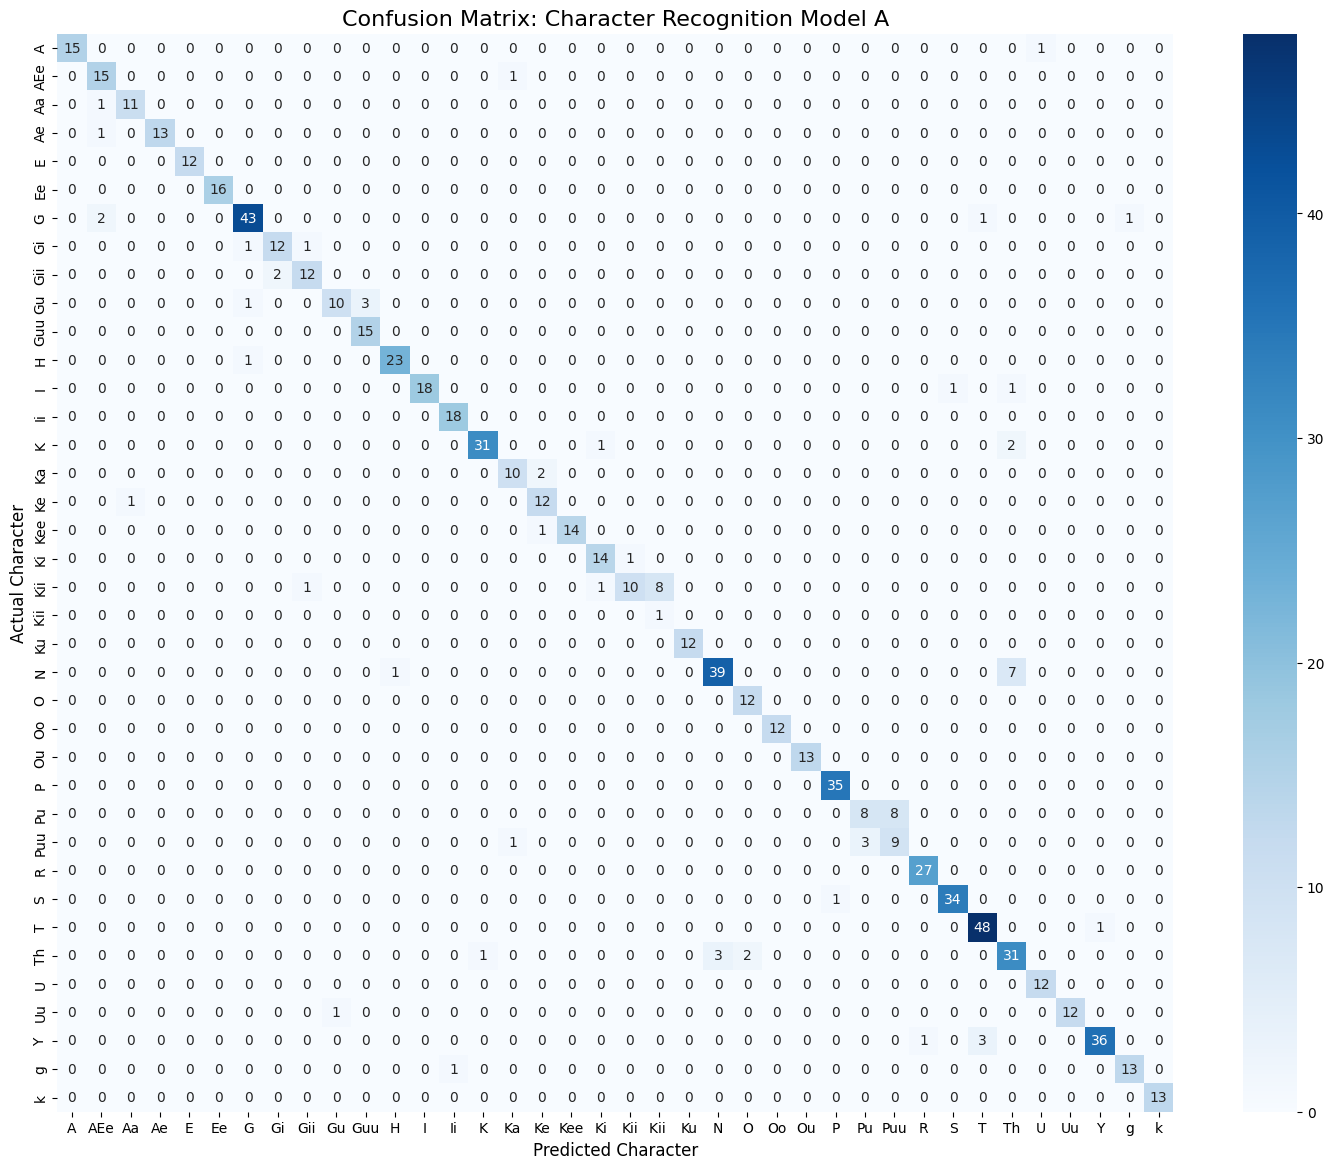

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Generating predictions on the test set
print("⏳ Generating predictions for evaluation...")
y_pred_probs = char_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# 1. Classification Report
# This provides a detailed breakdown of performance per character class
report = classification_report(y_c_test, y_pred, target_names=CONFIG["classes"])
print("\n📊 Detailed Classification Report:\n")
print(report)

# 2. Confusion Matrix Heatmap
# Rationale: Visualizing class confusion to identify similar-looking characters

plt.figure(figsize=(18, 14))
cm = confusion_matrix(y_c_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CONFIG["classes"], yticklabels=CONFIG["classes"])
plt.title("Confusion Matrix: Character Recognition Model A", fontsize=16)
plt.xlabel("Predicted Character", fontsize=12)
plt.ylabel("Actual Character", fontsize=12)
plt.show()

### 📊 Section 9.1: Discussion on Classification Performance

**Summary:**
The model achieved an overall **Accuracy of 91%** and a **Weighted F1-Score of 0.91** across 38 classes.

**Key Findings:**
1. **Model Robustness:** Characters like 'Ee', 'Oo', and 'k' reached a perfect F1-score, indicating that the LSTM effectively captured their sequential stroke patterns.
2. **Class Imbalance & Ambiguity:** The lower performance in 'Pu' (0.59) and 'Puu' (0.60) suggests a 'Feature Overlap' where the LSTM struggles to differentiate between highly similar stroke sequences.
3. **Data Quality Issues:** The near-failure of the 'Kii ' class (0.20) is attributed to a labeling anomaly (extra space in name) and insufficient training samples (Support=1).

**Proposed Improvement:**
To enhance the model, future iterations should involve merging redundant labels and increasing the sample size for visually similar character pairs through advanced data augmentation.

### 🟢 SECTION 10: QUALITATIVE ANALYSIS & VISUAL INSPECTION

**Description:**
This block performs a qualitative assessment by visualizing random samples from the test set alongside their predicted and ground-truth labels.

**Research Rationale:**
Visual inspection (Error Analysis) helps the researcher understand the model's behavior in real-world scenarios. It allows us to verify if the model struggles with specific stroke styles or noisy data points.

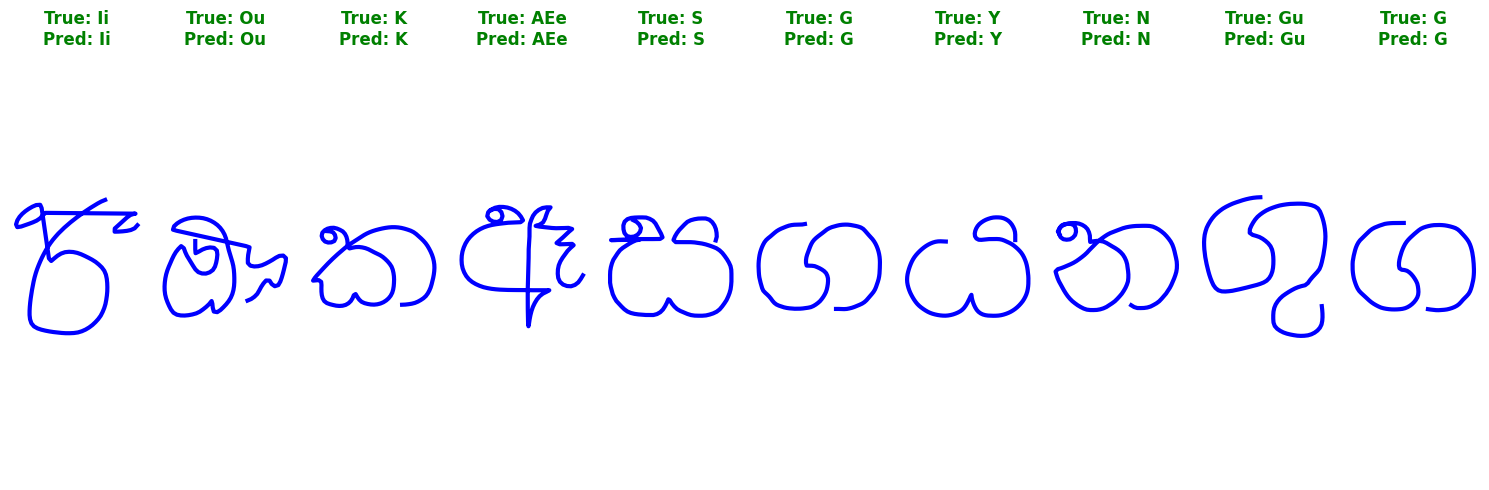

In [19]:
def plot_random_predictions(X, y_true, y_pred, classes, num_samples=20):
    """
    Randomly selects samples and plots them with prediction results.
    """
    indices = np.random.choice(len(X), num_samples, replace=False)
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        
        # Rescaling for visualization (inverse of 0-1 normalization)
        stroke = X[idx] 
        plt.plot(stroke[:, 0], stroke[:, 1], linewidth=3, color='blue')
        
        plt.gca().invert_yaxis() # Adjusting to canvas coordinates
        plt.axis('equal')
        plt.axis('off')
        
        is_correct = y_true[idx] == y_pred[idx]
        title_color = 'green' if is_correct else 'red'
        
        plt.title(f"True: {classes[y_true[idx]]}\nPred: {classes[y_pred[idx]]}", 
                  color=title_color, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Execute visual inspection
plot_random_predictions(X_test, y_c_test, y_pred, CONFIG["classes"])

### 🟢 SECTION 11: FINAL MODEL SERIALIZATION & PERSISTENCE

**Description:**
Exporting the trained model architecture, weights, and the feature scaler for future inference and production deployment.

**Research Rationale:**
Model persistence is crucial for reproducibility. By saving the **StandardScaler** along with the model, we ensure that the same statistical transformations ($\mu$ and $\sigma$) applied during training are used for new, real-time input data.

In [15]:
# 1. Saving the model in Keras format
model_filename = 'sinhala_mithuru_char_recognizer_v1.keras'
char_model.save(model_filename)

# 2. Saving the scaler parameters
scaler_filename = 'char_scaler_v1.pkl'
joblib.dump(scaler, scaler_filename)

print(f"✅ Research assets saved successfully:")
print(f"   - Model: {model_filename}")
print(f"   - Scaler: {scaler_filename}")

✅ Research assets saved successfully:
   - Model: sinhala_mithuru_char_recognizer_v1.keras
   - Scaler: char_scaler_v1.pkl
